#Prerequisite

In [ ]:
!pip install darts

#Importing necessary libraries

In [ ]:
from darts.datasets import AirPassengersDataset
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
import numpy as np
from darts.models import TFTModel
from darts.metrics import mae,mape

# Load the Airpassenger dataset

In [ ]:
ap_ts=AirPassengersDataset().load()
ap_ts

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[112.]],

       [[118.]],

       [[132.]],

       [[129.]],

       [[121.]],

       [[135.]],

       [[148.]],

       [[148.]],

       [[136.]],

       [[119.]],

...

       [[419.]],

       [[461.]],

       [[472.]],

       [[535.]],

       [[622.]],

       [[606.]],

       [[508.]],

       [[461.]],

       [[390.]],

       [[432.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# days in month

In [ ]:
TimeSeries.from_series(ap_ts.time_index.days_in_month)

<TimeSeries (DataArray) (time: 144, component: 1, sample: 1)>
array([[[31.]],

       [[28.]],

       [[31.]],

       [[30.]],

       [[31.]],

       [[30.]],

       [[31.]],

       [[31.]],

       [[30.]],

       [[31.]],

...

       [[31.]],

       [[30.]],

       [[31.]],

       [[30.]],

       [[31.]],

       [[31.]],

       [[30.]],

       [[31.]],

       [[30.]],

       [[31.]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 136 137 138 139 140 141 142 143
  * component  (component) object 'Month'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# monthly average

In [ ]:
ap_ts=ap_ts/TimeSeries.from_series(ap_ts.time_index.days_in_month)
ap_ts

<TimeSeries (DataArray) (Month: 144, component: 1, sample: 1)>
array([[[ 3.61290323]],

       [[ 4.21428571]],

       [[ 4.25806452]],

       [[ 4.3       ]],

       [[ 3.90322581]],

       [[ 4.5       ]],

       [[ 4.77419355]],

       [[ 4.77419355]],

       [[ 4.53333333]],

       [[ 3.83870968]],

...

       [[13.51612903]],

       [[15.36666667]],

       [[15.22580645]],

       [[17.83333333]],

       [[20.06451613]],

       [[19.5483871 ]],

       [[16.93333333]],

       [[14.87096774]],

       [[13.        ]],

       [[13.93548387]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# train and val

In [ ]:
train_ap, val_ap=ap_ts.split_after(pd.Timestamp("19571201"))
#or train_ap, val_ap=ap_ts.split_after(0.7)

<Axes: xlabel='Month'>

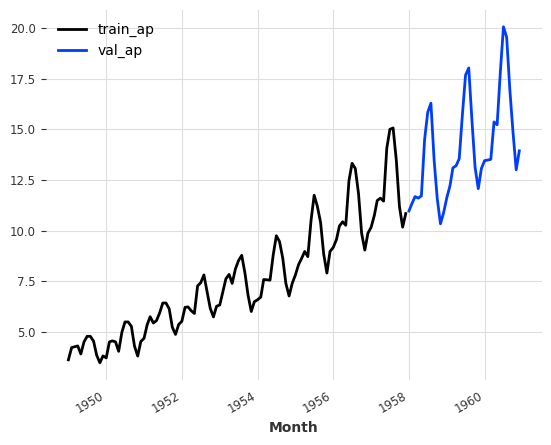

In [ ]:
# train_ap and val_ap plot
train_ap.plot(label="train_ap")
val_ap.plot(label="val_ap")

# scaling dataset

In [ ]:
sc=Scaler()
train_ap_sc=sc.fit_transform(train_ap)
val_ap_sc=sc.transform(val_ap)
ap_ts_sc=sc.transform(ap_ts)

# future covariate

In [ ]:
future_cov=datetime_attribute_timeseries(ap_ts_sc, attribute="year", one_hot=False)
future_cov=future_cov.stack(datetime_attribute_timeseries(ap_ts_sc, attribute="month", one_hot=False))
future_cov=future_cov.stack(TimeSeries.from_times_and_values(
    times=ap_ts_sc.time_index,
    values=np.arange(len(ap_ts_sc))
))
future_cov=future_cov.astype(np.float32)
future_cov

<TimeSeries (DataArray) (Month: 144, component: 3, sample: 1)>
array([[[1.949e+03],
        [1.000e+00],
        [0.000e+00]],

       [[1.949e+03],
        [2.000e+00],
        [1.000e+00]],

       [[1.949e+03],
        [3.000e+00],
        [2.000e+00]],

       [[1.949e+03],
        [4.000e+00],
        [3.000e+00]],

       [[1.949e+03],
        [5.000e+00],
        [4.000e+00]],

...

       [[1.960e+03],
        [8.000e+00],
        [1.390e+02]],

       [[1.960e+03],
        [9.000e+00],
        [1.400e+02]],

       [[1.960e+03],
        [1.000e+01],
        [1.410e+02]],

       [[1.960e+03],
        [1.100e+01],
        [1.420e+02]],

       [[1.960e+03],
        [1.200e+01],
        [1.430e+02]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1960-12-01
  * component  (component) object 'year' 'month' '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# train and val future cov

In [ ]:
train_future_cov, val_future_val_=future_cov.split_after(pd.Timestamp("19571201"))
#or train_future_cov, val_future_val_=future_cov.split_after(0.7))

#scalling future covariate

In [ ]:
sc_cov=Scaler()
future_cov_sc=sc_cov.fit_transform(future_cov)

#defining TFTModel

In [ ]:
tft_model=TFTModel(
    input_chunk_length=20,
    output_chunk_length=10,
    hidden_size=100,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    n_epochs=200
)

#fitting model with future covariates

In [ ]:
tft_model.fit(train_ap_sc,future_covariates=future_cov_sc)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 10.5 K
5  | decoder_vsn                       | _Vari

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


TFTModel(hidden_size=100, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=20, output_chunk_length=10, n_epochs=200)

In [ ]:
#saving model
tft_model.save("my_model.pt")

In [ ]:
#load model
model_loaded = tft_model.load("my_model.pt")

# evaluate and plot

In [ ]:
def model_evaluation(model, n, actual_data, val_data):
    num_samples = 200
    quantile01, quantile02, quantile03, quantile04 = 0.01, 0.1, 0.9, 0.99
    predicted_data = model.predict(n=n, num_samples=num_samples)

    plt.figure(figsize=(10, 6))
    actual_data[:predicted_data.end_time()].plot(label="actual")

    predicted_data.plot(
        low_quantile=quantile01,
        high_quantile=quantile04,
        label=f"{int(quantile01*100)}-{int(quantile04*100)}th percentage"
    )
    predicted_data.plot(
        low_quantile=quantile02,
        high_quantile=quantile03,
        label=f"{int(quantile02*100)}-{int(quantile03*100)}th percentage"
    )
    plt.title(f"MAE:{mae(val_ap_sc, predicted_data)},\
                MAPE:{mape(val_ap_sc, predicted_data)}"

    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

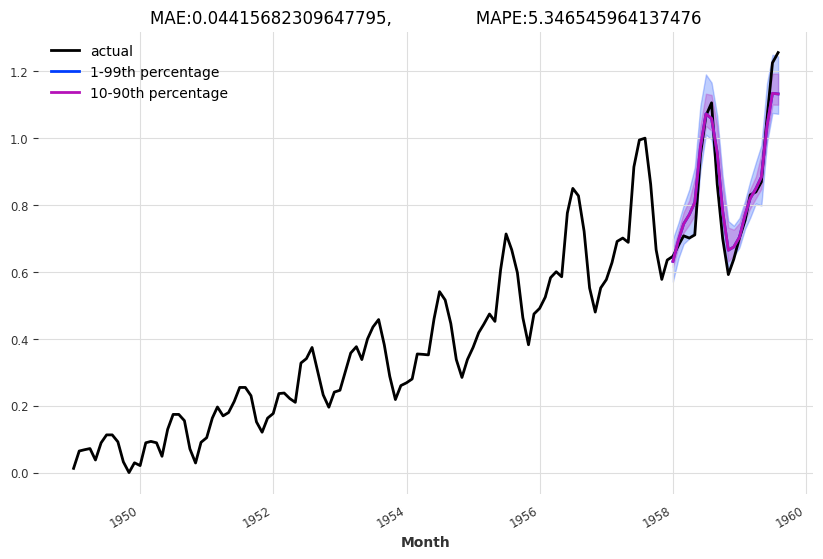

In [ ]:
model_evaluation(tft_model, 20, ap_ts_sc, val_ap_sc )